In [7]:
import pandas as pd
import numpy as np
# Load the raw data
fp = "/Users/pierfrancesco/Desktop/SleepStudy/wine_data_fixed.csv"
df = pd.read_csv(fp)

# df standardise:
df = (df - df.mean()) / df.std()


y = df['Alcohol'].values
df = df.drop(columns=['Alcohol'])

#X = df.drop(columns=['Alcohol'])
X = df
X = X.values
print(X.shape)


print(y.shape)

# Headings
attributeNames = df.columns.tolist()

(177, 12)
(177,)


In [8]:
y = y.reshape(-1,1)

print(y.shape)

(177, 1)


In [9]:
df.head()

,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,-0.500205,-0.822153,-2.493037,0.029098,0.571046,0.737544,-0.820810,-0.537052,-0.290307,0.405948,1.128497,0.968306
1,0.017969,1.104556,-0.274859,0.099649,0.810484,1.218189,-0.499919,2.139904,0.268966,0.318663,0.802303,1.397035
2,-0.348327,0.486555,-0.814416,0.946269,2.486555,1.468525,-0.981256,1.037628,1.181011,-0.423257,1.199408,2.333888
3,0.223452,1.831616,0.444550,1.299027,0.810484,0.667450,0.222086,0.407756,-0.316119,0.362306,0.461927,-0.032063
4,-0.518073,0.304790,-1.294022,0.875717,1.560726,1.368391,-0.179028,0.670203,0.729291,0.405948,0.348469,2.238614


X dataset (177, 12)
y dataset (177, 1)
Cross validation fold 1/5
Train indices: [  0   1   2   3   4   7   9  10  11  12  13  15  16  17  18  19  20  23
  25  26  28  29  30  31  32  33  34  35  36  37  39  40  41  42  43  44
  45  46  47  48  50  51  52  53  54  56  57  58  59  60  62  63  64  65
  66  68  69  70  71  73  74  76  77  78  79  80  81  83  84  85  87  88
  89  90  91  93  96  97  98  99 100 101 103 105 106 109 110 111 112 113
 114 115 116 117 120 121 122 123 124 125 126 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 145 147 148 150 151 152 153 154 155
 156 157 158 159 163 164 165 166 167 169 170 171 173 174 175]
Test indices: [  5   6   8  14  21  22  24  27  38  49  55  61  67  72  75  82  86  92
  94  95 102 104 107 108 118 119 127 144 146 149 160 161 162 168 172 176]
Features no: 3

Cross validation fold 2/5
Train indices: [  0   1   2   3   5   6   7   8  10  11  12  13  14  15  17  18  19  20
  21  22  23  24  25  26  27  29  30  31  33  34  35  36

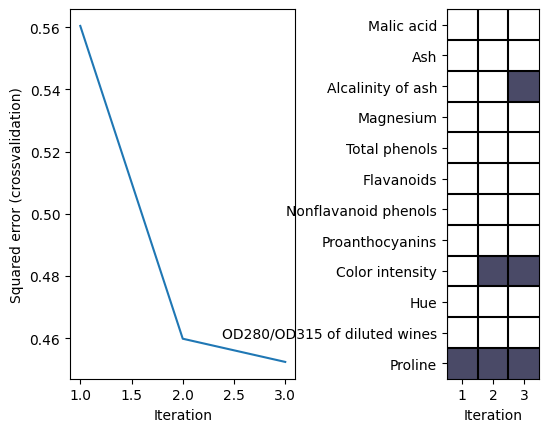

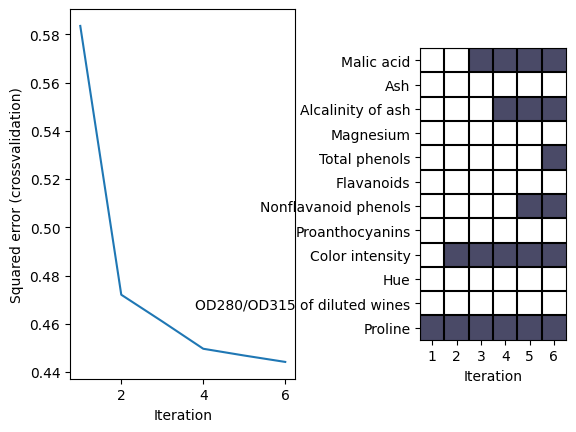

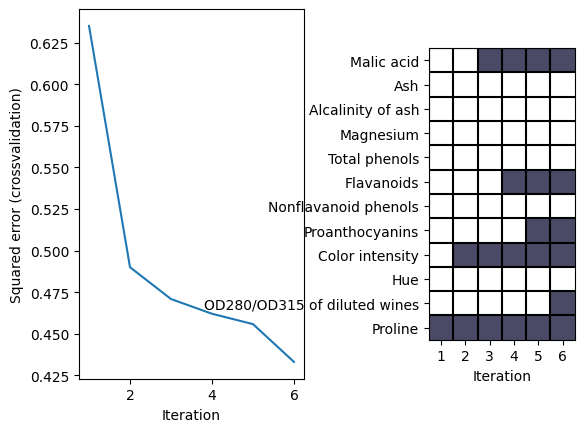

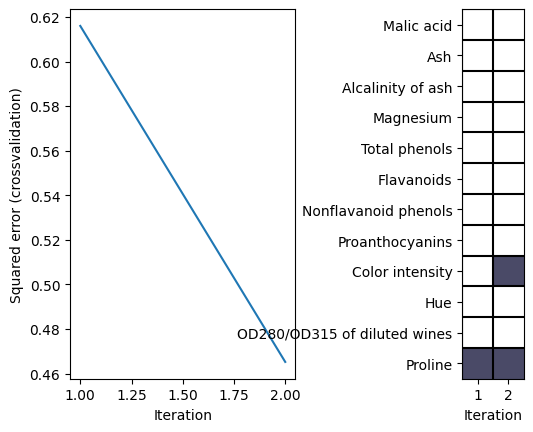

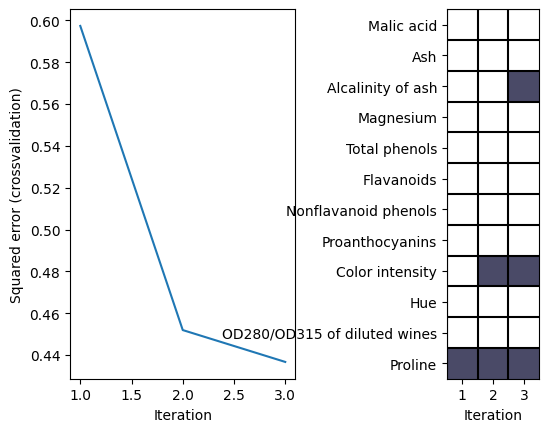

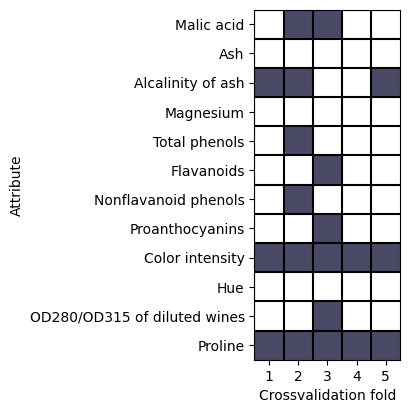

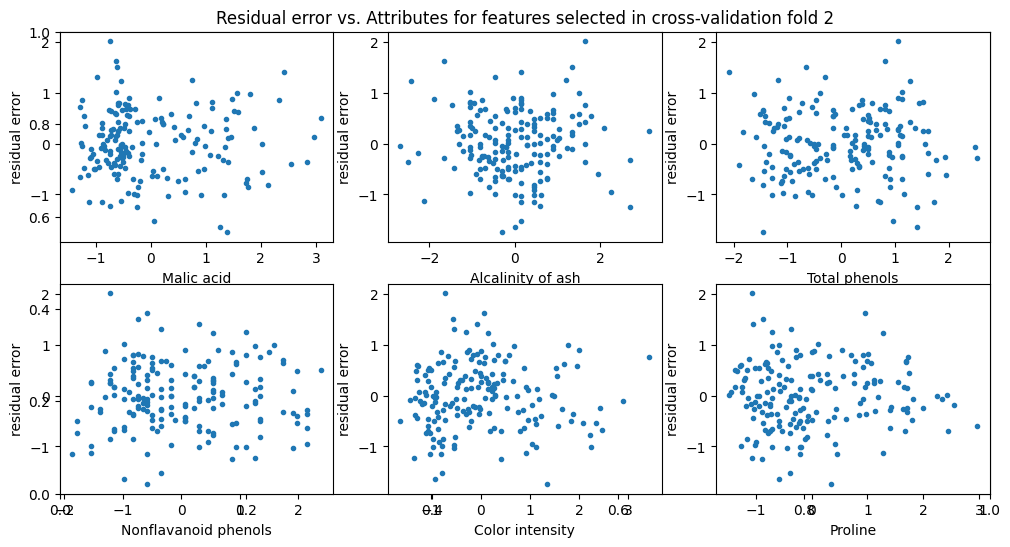

Ran Exercise 6.2.1


In [10]:
import importlib_resources
import numpy as np
import sklearn.linear_model as lm
from matplotlib.pyplot import clim, figure, plot, show, subplot, title, xlabel, ylabel
from scipy.io import loadmat
from sklearn import model_selection

from dtuimldmtools import bmplot, feature_selector_lr

#filename = importlib_resources.files("dtuimldmtools").joinpath("data/body.mat")
# Load data from matlab file
#mat_data = loadmat(filename)

#X = mat_data['X']
#y = mat_data['y'].squeeze()

print("X dataset", X.shape)
print("y dataset", y.shape)

#attributeNames = [name[0] for name in mat_data['attributeNames'][0]]
N, M = X.shape


## Crossvalidation
# Create crossvalidation partition for evaluation
K = 5
CV = model_selection.KFold(n_splits=K,shuffle=True)

# Initialize variables
Features = np.zeros((M,K))
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_fs = np.empty((K,1))
Error_test_fs = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))

k=0
for train_index, test_index in CV.split(X):
    
    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]
    internal_cross_validation = 10
    
    # Compute squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum()/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum()/y_test.shape[0]

    # Compute squared error with all features selected (no feature selection)
    m = lm.LinearRegression(fit_intercept=True).fit(X_train, y_train)
    Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Compute squared error with feature subset selection
    textout = ''
    selected_features, features_record, loss_record = feature_selector_lr(X_train, y_train, internal_cross_validation,display=textout)
    
    Features[selected_features,k] = 1
    # .. alternatively you could use module sklearn.feature_selection
    if len(selected_features) == 0:
        print('No features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
    else:
        m = lm.LinearRegression(fit_intercept=True).fit(X_train[:,selected_features], y_train)
        Error_train_fs[k] = np.square(y_train-m.predict(X_train[:,selected_features])).sum()/y_train.shape[0]
        Error_test_fs[k] = np.square(y_test-m.predict(X_test[:,selected_features])).sum()/y_test.shape[0]
    
        figure(k)
        subplot(1,2,1)
        plot(range(1,len(loss_record)), loss_record[1:])
        xlabel('Iteration')
        ylabel('Squared error (crossvalidation)')    
        
        subplot(1,3,3)
        bmplot(attributeNames, range(1,features_record.shape[1]), -features_record[:,1:])
        clim(-1.5,0)
        xlabel('Iteration')

    print('Cross validation fold {0}/{1}'.format(k+1,K))
    print('Train indices: {0}'.format(train_index))
    print('Test indices: {0}'.format(test_index))
    print('Features no: {0}\n'.format(selected_features.size))

    k+=1


# Display results
print('\n')
print('Linear regression without feature selection:\n')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Linear regression with feature selection:\n')
print('- Training error: {0}'.format(Error_train_fs.mean()))
print('- Test error:     {0}'.format(Error_test_fs.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_fs.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test_fs.sum())/Error_test_nofeatures.sum()))

figure(k)
subplot(1,3,2)
bmplot(attributeNames, range(1,Features.shape[1]+1), -Features)
clim(-1.5,0)
xlabel('Crossvalidation fold')
ylabel('Attribute')


# Inspect selected feature coefficients effect on the entire dataset and
# plot the fitted model residual error as function of each attribute to
# inspect for systematic structure in the residual

f=2 # cross-validation fold to inspect
ff=Features[:,f-1].nonzero()[0]
if len(ff) == 0:
    print('\nNo features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
else:
    m = lm.LinearRegression(fit_intercept=True).fit(X[:,ff], y)
    
    y_est= m.predict(X[:,ff])
    residual=y-y_est
    
    figure(k+1, figsize=(12,6))
    title('Residual error vs. Attributes for features selected in cross-validation fold {0}'.format(f))
    for i in range(0,len(ff)):
       subplot(2, int( np.ceil(len(ff)/2)), i+1)
       plot(X[:,ff[i]],residual,'.')
       xlabel(attributeNames[ff[i]])
       ylabel('residual error')
    
    
show()

print('Ran Exercise 6.2.1')

In [11]:
def PlotGenErr(testErr, k, lambdas):
    genErr = testErr * 1/k
    figure(k, figsize=(12,8))
    plot(genErr, lambdas)
    show()

In [12]:
# exercise 8.1.1

import importlib_resources
import numpy as np
import sklearn.linear_model as lm
from matplotlib.pylab import (
    figure,
    grid,
    legend,
    loglog,
    semilogx,
    show,
    subplot,
    title,
    xlabel,
    ylabel,
)
from scipy.io import loadmat
from sklearn import model_selection

from dtuimldmtools import rlr_validate

#filename = importlib_resources.files("dtuimldmtools").joinpath("data/body.mat")


#mat_data = loadmat(filename)
#X = mat_data["X"]
#y = mat_data["y"].squeeze()
#attributeNames = [name[0] for name in mat_data["attributeNames"][0]]
N, M = X.shape

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
attributeNames = ["Offset"] + attributeNames
M = M + 1

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 5
CV = model_selection.KFold(K, shuffle=True)
# CV = model_selection.KFold(K, shuffle=False)

# Values of lambda
lambdas = np.power(10.0, range(-5, 9))

# Initialize variables
# T = len(lambdas)
Error_train = np.empty((K, 1))
Error_test = np.empty((K, 1))
Error_train_rlr = np.empty((K, 1))
Error_test_rlr = np.empty((K, 1))
Error_train_nofeatures = np.empty((K, 1))
Error_test_nofeatures = np.empty((K, 1))
w_rlr = np.empty((M, K))
mu = np.empty((K, M - 1))
sigma = np.empty((K, M - 1))
w_noreg = np.empty((M, K))

k = 0
for train_index, test_index in CV.split(X, y):
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10

    (
        opt_val_err,
        opt_lambda,
        mean_w_vs_lambda,
        train_err_vs_lambda,
        test_err_vs_lambda,
    ) = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)

    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :]) / sigma[k, :]
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :]) / sigma[k, :]

    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = (
        np.square(y_train - y_train.mean()).sum(axis=0) / y_train.shape[0]
    )
    Error_test_nofeatures[k] = (
        np.square(y_test - y_test.mean()).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0, 0] = 0  # Do no regularize the bias term
    w_rlr[:, k] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()

    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = (
        np.square(y_train - X_train @ w_rlr[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test_rlr[k] = (
        np.square(y_test - X_test @ w_rlr[:, k]).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:, k] = np.linalg.solve(XtX, Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = (
        np.square(y_train - X_train @ w_noreg[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test[k] = (
        np.square(y_test - X_test @ w_noreg[:, k]).sum(axis=0) / y_test.shape[0]
    )
    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    # m = lm.LinearRegression().fit(X_train, y_train)
    # Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    # Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K - 1:
        figure(k, figsize=(12, 8))
        subplot(1, 2, 1)
        semilogx(lambdas, mean_w_vs_lambda.T[:, 1:], ".-")  # Don't plot the bias term
        xlabel("Regularization factor")
        ylabel("Mean Coefficient Values")
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner
        # plot, since there are many attributes
        # legend(attributeNames[1:], loc='best')

        subplot(1, 2, 2)
        title("Optimal lambda: 1e{0}".format(np.log10(opt_lambda)))
        loglog(
            lambdas, train_err_vs_lambda.T, "b.-", lambdas, test_err_vs_lambda.T, "r.-"
        )
        xlabel("Regularization factor")
        ylabel("Squared error (crossvalidation)")
        legend(["Train error", "Validation error"])
        grid()

        #PlotGenErr(test_err_vs_lambda, k, lambdas)


    # To inspect the used indices, use these print statements
    # print('Cross validation fold {0}/{1}:'.format(k+1,K))
    # print('Train indices: {0}'.format(train_index))
    # print('Test indices: {0}\n'.format(test_index))

    k += 1

show()




# Display results
print("Linear regression without feature selection:")
print("- Training error: {0}".format(Error_train.mean()))
print("- Test error:     {0}".format(Error_test.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test.sum()) / Error_test_nofeatures.sum()
    )
)
print("Regularized linear regression:")
print("- Training error: {0}".format(Error_train_rlr.mean()))
print("- Test error:     {0}".format(Error_test_rlr.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train_rlr.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test_rlr.sum())
        / Error_test_nofeatures.sum()
    )
)

print("Weights in last fold:")
for m in range(M):
    print("{:>15} {:>15}".format(attributeNames[m], np.round(w_rlr[m, -1], 2)))

print("Ran Exercise 8.1.1")



ValueError: could not broadcast input array from shape (141,) into shape (1,)

# ANN Stuff

In [ ]:
# Retain the splits so that we can re-run the models on the same data
K = 5  
CV = model_selection.KFold(K, shuffle=True, random_state=123)
splits = list(CV.split(X, y)) #list because the generator can be exhausted.



In [ ]:
# exercise 8.2.6
import importlib_resources
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import stats
from scipy.io import loadmat
from sklearn import model_selection

from dtuimldmtools import draw_neural_net, train_neural_net

N, M = X.shape
C = 2

# Normalize data
X = stats.zscore(X)

## Normalize and compute PCA (change to True to experiment with PCA preprocessing)
do_pca_preprocessing = False
if do_pca_preprocessing:
    Y = stats.zscore(X, 0)
    U, S, V = np.linalg.svd(Y, full_matrices=False)
    V = V.T
    # Components to be included as features
    k_pca = 3
    X = X @ V[:, :k_pca]
    N, M = X.shape


# Parameters for neural network classifier
n_hidden_units = 20  # number of hidden units
n_replicates = 1  # number of networks trained in each k-fold
max_iter = 10000

# K-fold crossvalidation
#K = 5  # only three folds to speed up this example
#CV = model_selection.KFold(K, shuffle=True, random_state=123)

# Setup figure for display of learning curves and error rates in fold
summaries, summaries_axes = plt.subplots(1, 2, figsize=(10, 5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = [
    "tab:orange",
    "tab:green",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
    "tab:red",
    "tab:blue",
]
# Define the model
model = lambda: torch.nn.Sequential(
    torch.nn.Linear(M, n_hidden_units),  # M features to n_hidden_units
    torch.nn.Tanh(),  # 1st transfer function,
    torch.nn.Linear(n_hidden_units, 1),  # n_hidden_units to 1 output neuron
    # no final tranfer function, i.e. "linear output"
)
loss_fn = torch.nn.MSELoss()  # notice how this is now a mean-squared-error loss

print("Training model of type:\n\n{}\n".format(str(model())))
errors = []  # make a list for storing generalizaition error in each loop
for k, (train_index, test_index) in enumerate(splits):
    print("\nCrossvalidation fold: {0}/{1}".format(k + 1, K))

    # Extract training and test set for current CV fold, convert to tensors
    X_train = torch.Tensor(X[train_index, :])
    y_train = torch.Tensor(y[train_index])
    X_test = torch.Tensor(X[test_index, :])
    y_test = torch.Tensor(y[test_index])

    # Train the net on training data
    net, final_loss, learning_curve = train_neural_net(
        model,
        loss_fn,
        X=X_train,
        y=y_train,
        n_replicates=n_replicates,
        max_iter=max_iter,
    )

    print("\n\tBest loss: {}\n".format(final_loss))

    # Determine estimated class labels for test set
    y_test_est = net(X_test)

    # Determine errors and errors
    se = (y_test_est.float() - y_test.float()) ** 2  # squared error
    mse = (sum(se).type(torch.float) / len(y_test)).data.numpy()  # mean
    errors.append(mse)  # store error rate for current CV fold

    # Display the learning curve for the best net in the current fold
    (h,) = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label("CV fold {0}".format(k + 1))
    summaries_axes[0].set_xlabel("Iterations")
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel("Loss")
    summaries_axes[0].set_title("Learning curves")

# Display the MSE across folds
summaries_axes[1].bar(
    np.arange(1, K + 1), np.squeeze(np.asarray(errors)), color=color_list
)
summaries_axes[1].set_xlabel("Fold")
summaries_axes[1].set_xticks(np.arange(1, K + 1))
summaries_axes[1].set_ylabel("MSE")
summaries_axes[1].set_title("Test mean-squared-error")

print("Diagram of best neural net in last fold:")
weights = [net[i].weight.data.numpy().T for i in [0, 2]]
biases = [net[i].bias.data.numpy() for i in [0, 2]]
tf = [str(net[i]) for i in [1, 2]]
draw_neural_net(weights, biases, tf, attribute_names=attributeNames)

# Print the average classification error rate
print(
    "\nEstimated generalization error, RMSE: {0}".format(
        round(np.sqrt(np.mean(errors)), 4)
    )
)

# When dealing with regression outputs, a simple way of looking at the quality
# of predictions visually is by plotting the estimated value as a function of
# the true/known value - these values should all be along a straight line "y=x",
# and if the points are above the line, the model overestimates, whereas if the
# points are below the y=x line, then the model underestimates the value
plt.figure(figsize=(10, 10))
y_est = y_test_est.data.numpy()
y_true = y_test.data.numpy()
axis_range = [np.min([y_est, y_true]) - 1, np.max([y_est, y_true]) + 1]
plt.plot(axis_range, axis_range, "k--")
plt.plot(y_true, y_est, "ob", alpha=0.25)
plt.legend(["Perfect estimation", "Model estimations"])
plt.title("Alcohol content: estimated versus true value (for last CV-fold)")
plt.ylim(axis_range)
plt.xlim(axis_range)
plt.xlabel("True value")
plt.ylabel("Estimated value")
plt.grid()

plt.show()

print("Ran Exercise 8.2.5")


In [ ]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from collections import Counter
from dtuimldmtools import rlr_validate  # Assuming this is the correct import

# Load dataset function
def load_data(filepath):
    data = pd.read_csv(filepath)
    y = data.iloc[1:, 0] - 1  # Adjust labels to be zero-indexed for PyTorch
    X = data.iloc[1:, 1:]
    return X.values, y.values

# Function for ANN classifier
class ANNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_units, num_classes):
        super(ANNClassifier, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_units)
        self.output = nn.Linear(hidden_units, num_classes)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.hidden(x))
        x = self.output(x)
        return x

# Function to train ANN
def train_ann(X_train, y_train, X_val, hidden_units=20, max_iter=2000):
    input_dim = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    model = ANNClassifier(input_dim, hidden_units, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)

    for epoch in range(max_iter):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        outputs_val = model(X_val_tensor)
        _, predictions = torch.max(outputs_val, 1)
    return predictions.numpy()

# Baseline method
def baseline_method(y_train, y_test):
    most_common_class = Counter(y_train).most_common(1)[0][0]
    predictions = np.full_like(y_test, most_common_class)
    return predictions

# Load the data
filepath = "/Users/pierfrancesco/Desktop/SleepStudy/raw_data/wine.csv"
X, y = load_data(filepath)
# Normalize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Define cross-validation parameters
K1 = 3  # Outer folds
K2 = 3  # Inner folds
kf_outer = KFold(n_splits=K1, shuffle=True, random_state=42)

# Define the set of discrete lambda values
lambdas = np.array([1, 2, 5, 10])  # Fixed discrete set

results_summary = []

# Outer cross-validation loop
for outer_fold, (train_index, test_index) in enumerate(kf_outer.split(X), start=1):
    X_outer_train, X_outer_test = X[train_index], X[test_index]
    y_outer_train, y_outer_test = y[train_index], y[test_index]

    # Inner cross-validation for Logistic Regression using rlr_validate
    internal_cv = K2
    opt_val_err, best_lambda, _, _, _ = rlr_validate(X_outer_train, y_outer_train, lambdas, internal_cv)

    # Ensure best_lambda is chosen strictly from the predefined lambdas
    assert best_lambda in lambdas, f"Unexpected λ value: {best_lambda}"

    # Train Logistic Regression on outer fold with best lambda
    logreg_model = LogisticRegression(C=1/best_lambda, max_iter=1000, multi_class='multinomial')
    logreg_model.fit(X_outer_train, y_outer_train)
    logreg_pred = logreg_model.predict(X_outer_test)
    logreg_acc = accuracy_score(y_outer_test, logreg_pred)

    # Inner cross-validation for ANN
    hidden_units_values = [1,2,5,10,25,50]
    best_ann_acc = 0
    best_hidden_units = None

    for hidden_units in hidden_units_values:
        inner_acc = []
        for train_idx, val_idx in KFold(n_splits=K2, shuffle=True, random_state=42).split(X_outer_train):
            X_train, X_val = X_outer_train[train_idx], X_outer_train[val_idx]
            y_train, y_val = y_outer_train[train_idx], y_outer_train[val_idx]

            ann_pred = train_ann(X_train, y_train, X_val, hidden_units=hidden_units)
            val_acc = accuracy_score(y_val, ann_pred)
            inner_acc.append(val_acc)

        mean_acc = np.mean(inner_acc)
        if mean_acc > best_ann_acc:
            best_ann_acc = mean_acc
            best_hidden_units = hidden_units

    print(f"Selected hidden units for outer fold {outer_fold}: {best_hidden_units}\n")

    # Train final ANN with the best hyperparameters
    ann_pred = train_ann(X_outer_train, y_outer_train, X_outer_test, hidden_units=best_hidden_units)
    ann_acc = accuracy_score(y_outer_test, ann_pred)

    # Baseline model
    baseline_pred = baseline_method(y_outer_train, y_outer_test)
    baseline_acc = accuracy_score(y_outer_test, baseline_pred)

    # Store results
    results_summary.append({
        'Outer fold': outer_fold,
        'ANN Hidden Units': best_hidden_units,
        'ANN Accuracy': round(ann_acc, 4),
        'Logistic Regression (λ*)': best_lambda,
        'Logistic Accuracy': round(logreg_acc, 4),
        'Baseline Accuracy': round(baseline_acc, 4)
    })

# Convert results to DataFrame and print
results_df = pd.DataFrame(results_summary)
print("\nTwo-level cross-validation table:")
print(results_df.to_string(index=False))


Selected hidden units for outer fold 1: 50

Selected hidden units for outer fold 2: 2

Selected hidden units for outer fold 3: 2


Two-level cross-validation table:
 Outer fold  ANN Hidden Units  ANN Accuracy  Logistic Regression (λ*)  Logistic Accuracy  Baseline Accuracy
          1                50        0.9492                        10             0.9661             0.4237
          2                 2        0.9322                         1             0.9661             0.3898
          3                 2        1.0000                         1             0.9831             0.3898


In [ ]:
from scipy.stats import ttest_rel

logreg_acc_scores = results_df['Logistic Accuracy'].values
ann_acc_scores = results_df['ANN Accuracy'].values
baseline_acc_scores = results_df['Baseline Accuracy'].values

_, p_logreg_vs_baseline = ttest_rel(logreg_acc_scores, baseline_acc_scores)
_, p_ann_vs_baseline = ttest_rel(ann_acc_scores, baseline_acc_scores)
_, p_ann_vs_logreg = ttest_rel(ann_acc_scores, logreg_acc_scores)

print(f"p-value for Logistic Regression vs. Baseline: {p_logreg_vs_baseline}")
print(f"p-value for ANN vs. Baseline: {p_ann_vs_baseline}")
print(f"p-value for ANN vs. Logistic Regression: {p_ann_vs_logreg}")

p-value for Logistic Regression vs. Baseline: 0.0006866168179413037
p-value for ANN vs. Baseline: 0.002133856473775577
p-value for ANN vs. Logistic Regression: 0.5281319555042806


In [ ]:
def confidence_interval(data1, data2, confidence=0.95):
    differences = np.array(data1) - np.array(data2)
    mean_diff = np.mean(differences)
    se_diff = np.std(differences, ddof=1) / np.sqrt(len(differences))
    margin = se_diff * 1.96 
    return mean_diff - margin, mean_diff + margin

ci_logreg_vs_baseline = confidence_interval(logreg_acc_scores, baseline_acc_scores)
ci_ann_vs_baseline = confidence_interval(ann_acc_scores, baseline_acc_scores)
ci_ann_vs_logreg = confidence_interval(ann_acc_scores, logreg_acc_scores)

print(f"95% CI for Logistic Regression vs. Baseline: {ci_logreg_vs_baseline}")
print(f"95% CI for ANN vs. Baseline: {ci_ann_vs_baseline}")
print(f"95% CI for ANN vs. Logistic Regression: {ci_ann_vs_logreg}")

95% CI for Logistic Regression vs. Baseline: (np.float64(0.5413429151710313), np.float64(0.599990418162302))
95% CI for ANN vs. Baseline: (np.float64(0.5086406027634708), np.float64(0.6100927305698626))
95% CI for ANN vs. Logistic Regression: (np.float64(-0.040562040758178985), np.float64(0.01796204075817911))


In [32]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from collections import Counter
from dtuimldmtools import rlr_validate  # Assuming this is the correct import

# Load dataset function
def load_data(filepath):
    data = pd.read_csv(filepath)
    y = data.iloc[1:, 0] - 1  # Adjust labels to be zero-indexed for PyTorch
    X = data.iloc[1:, 1:]
    attributes_name = data.columns[1:]
    return X.values, y.values, attributes_name

# Load the data
filepath = "/Users/pierfrancesco/Desktop/SleepStudy/raw_data/wine.csv"
X, y, attributes_name = load_data(filepath)
# Normalize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Define cross-validation parameters
K1 = 3  # Outer folds
kf_outer = KFold(n_splits=K1, shuffle=True, random_state=42)

# Define the set of discrete lambda values
lambdas = np.array([1, 2, 5, 10])  # Fixed discrete set

results_summary = []

# Outer cross-validation loop
for outer_fold, (train_index, test_index) in enumerate(kf_outer.split(X), start=1):
    X_outer_train, X_outer_test = X[train_index], X[test_index]
    y_outer_train, y_outer_test = y[train_index], y[test_index]

    internal_cv = 2  
    opt_val_err, best_lambda, _, _, _ = rlr_validate(X_outer_train, y_outer_train, lambdas, internal_cv)

    # Ensure best_lambda is chosen strictly from the predefined lambdas
    assert best_lambda in lambdas, f"Unexpected λ value: {best_lambda}"

    # Train Logistic Regression on outer fold with best lambda
    logreg_model = LogisticRegression(C=1/best_lambda, max_iter=1000, multi_class='multinomial')
    logreg_model.fit(X_outer_train, y_outer_train)
    logreg_pred = logreg_model.predict(X_outer_test)
    logreg_acc = accuracy_score(y_outer_test, logreg_pred)


    # Store results
    results_summary.append({
        'Logistic Regression (λ*)': best_lambda,
        'Logistic Accuracy': round(logreg_acc, 4),
    })

logreg_weights = logreg_model.coef_

# Print the weights for each class
print("\nLogistic Regression Model Weights (per class):")
for class_idx, class_weights in enumerate(logreg_weights):
    print(f"Class {class_idx} weights:", class_weights)

# Convert results to DataFrame and print
results_df = pd.DataFrame(results_summary)
print("\nTwo-level cross-validation table:")
print(results_df.to_string(index=False))


Logistic Regression Model Weights (per class):
Class 0 weights: [ 0.7640398   0.11252345  0.38964359 -0.44572225  0.0740056   0.21965593
  0.44262431 -0.25574287  0.13582183  0.10922509  0.19781055  0.54028375
  0.80844488]
Class 1 weights: [-0.8713056  -0.34616908 -0.61477349  0.22498214 -0.04021393 -0.01273826
  0.38517537  0.1406837   0.19206808 -0.76886743  0.38661939 -0.02063106
 -0.84049494]
Class 2 weights: [ 0.10726581  0.23364562  0.2251299   0.22074011 -0.03379167 -0.20691766
 -0.82779968  0.11505917 -0.32788991  0.65964234 -0.58442995 -0.5196527
  0.03205006]

Two-level cross-validation table:
 Logistic Regression (λ*)  Logistic Accuracy
                       10             0.9661
                        1             0.9661
                        2             0.9831
Index(['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium',
       'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
       'Proanthocyanins', 'Color intensity', 'Hue',
       'OD280/OD315 